In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


df = pd.read_csv('~/Pycharmprojects/PredictingPatientReadmission/datasets/County_Pop_Income_RR.csv')
df.head()

Year     County ICD Version  Total Admits (Consolidated)  \
0  2011    Alameda       ICD-9                      75103.0   
1  2011     Alpine       ICD-9                         13.0   
2  2011     Amador       ICD-9                       2657.0   
3  2011      Butte       ICD-9                      20422.0   
4  2011  Calaveras       ICD-9                       3253.0   

   30-day Readmits (Consolidated)  30-day Readmission Rate (Consolidated)  \
0                         11377.0                                    15.1   
1                             1.0                                     7.7   
2                           345.0                                    13.0   
3                          3198.0                                    15.7   
4                           392.0                                    12.1   

      PCPI  Population  
0  50432.0     1530893  
1  54040.0        1093  
2  34847.0       37539  
3  33669.0      219983  
4  37516.0       45159

To start it will be helpful to visualize the trends of County Population and 30-day Readmission Rate.

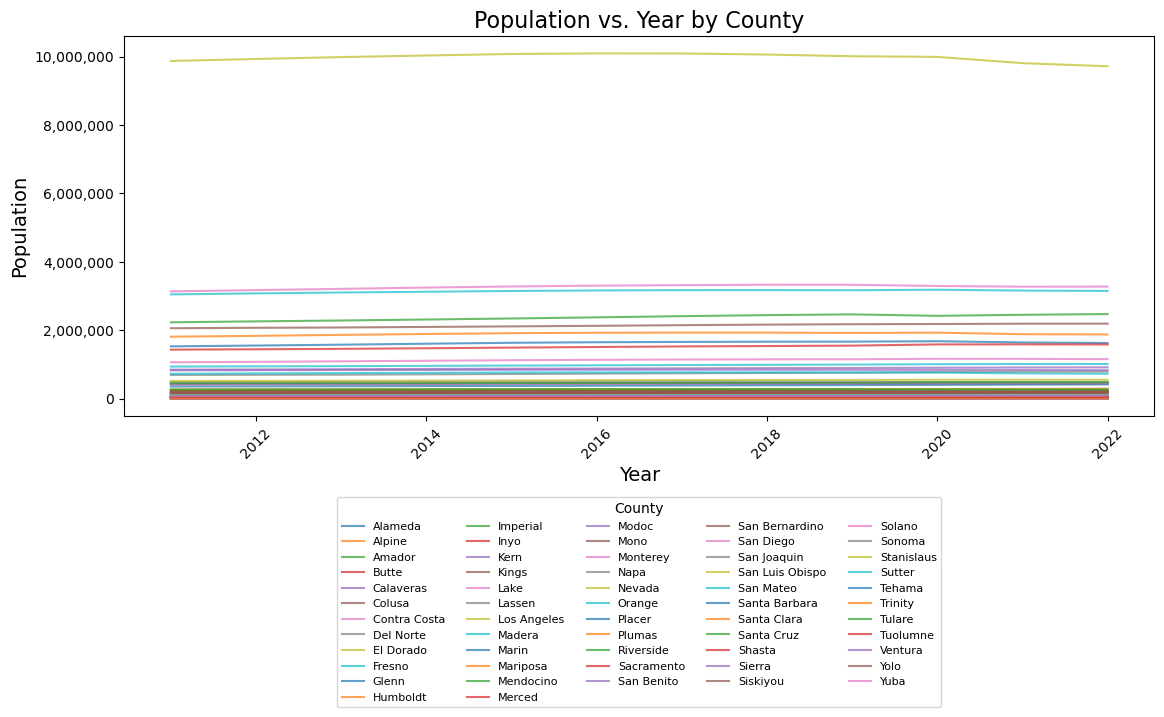

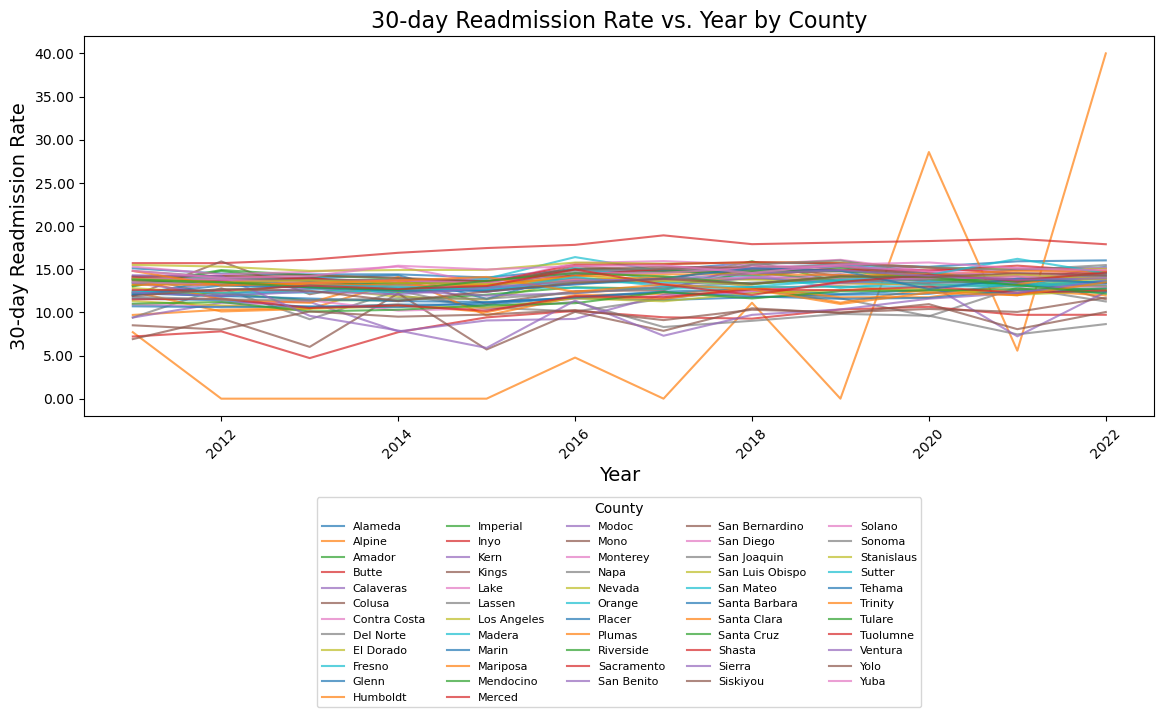

In [2]:
# Line plot for Population vs. Year
plt.figure(figsize=(12, 8))  # Increased height
for county, data in df.groupby('County'):
    plt.plot(data['Year'], data['Population'], label=county, alpha=0.7)
plt.title("Population vs. Year by County", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Population", fontsize=14)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))  # Full number formatting
plt.legend(
    title="County",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),  # Lower the legend by decreasing the second value
    ncol=5,  # Number of columns for horizontal layout
    fontsize=8
)
plt.tight_layout(pad=2.0)  # Adjust layout
plt.show()

# Line plot for 30-day Readmission Rate vs. Year
plt.figure(figsize=(12, 8))  # Increased height
for county, data in df.groupby('County'):
    plt.plot(data['Year'], data['30-day Readmission Rate (Consolidated)'], label=county, alpha=0.7)
plt.title("30-day Readmission Rate vs. Year by County", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("30-day Readmission Rate", fontsize=14)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))  # Two decimal places for rates
plt.legend(
    title="County",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),  # Lower the legend by decreasing the second value
    ncol=5,  # Number of columns for horizontal layout
    fontsize=8
)
plt.tight_layout(pad=2.0)  # Adjust layout
plt.show()


There are two noteworthy observations to takeaway from these visuals:

1. There appears to be substantial population outliers with most counties having a population less than 1 million, but several in the range of 1.5-3 million, and one approaching 10 million. 

2. The county with the greatest variation in 30-day Readmission Rate annual trends, Alpine (Ranging from ~8%-~40%), is also a population outlier with one of the smallest populations.

These outlier intuitions will be important moving forward.

Next how do these variables relate to each other now that county population is factored into the analysis?

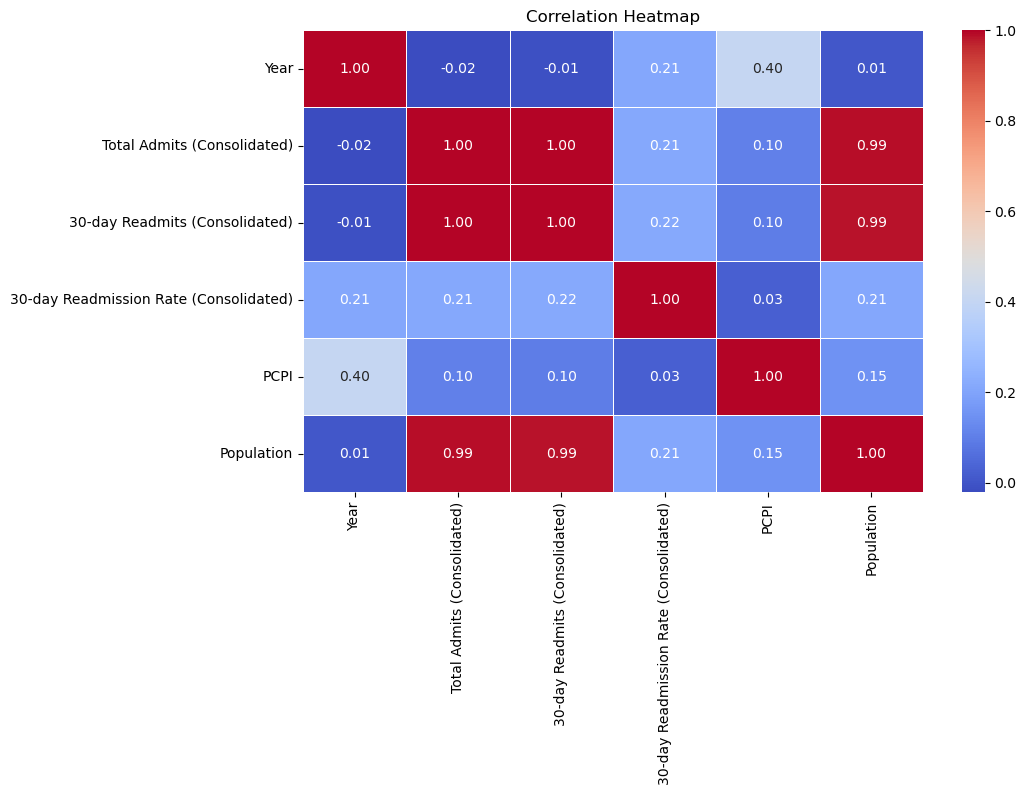

In [3]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

There is a very strong correlation between Population with both Total Admits and 30-day Readmits.

This observation is worth investigating more, however this correlation calculation may be impacted by outliers.

The next visualization will aim to visualize outlier counties for the Population variable in order to determine if a more robust correlation calculation is necessary.

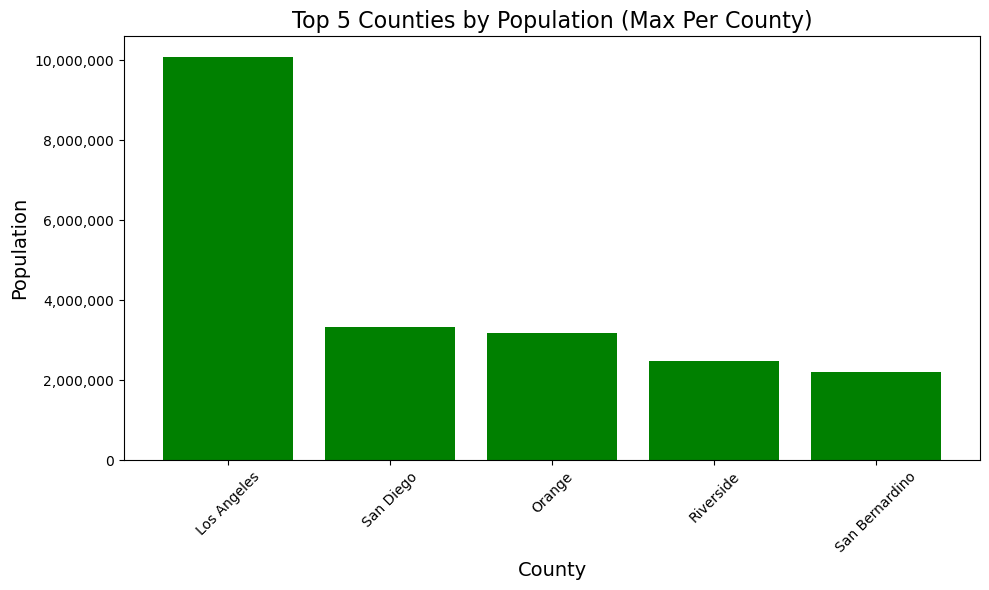

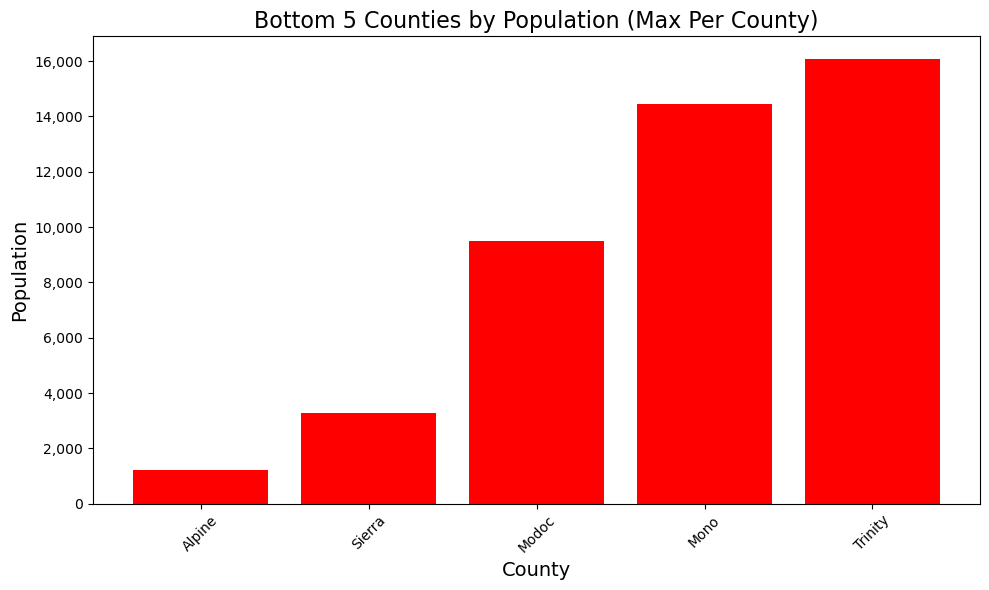

In [4]:
# Get the maximum population for each county across all years
unique_counties = df.groupby('County').agg({
    'Population': 'max'
}).reset_index()

# Helper function to get top and bottom 5 counties for Population
def get_top_bottom(df, column):
    top_5 = df.nlargest(5, column)[['County', column]]
    bottom_5 = df.nsmallest(5, column)[['County', column]]
    return top_5, bottom_5

# Focus only on Population
top_5, bottom_5 = get_top_bottom(unique_counties, 'Population')

# Plot top 5 counties
plt.figure(figsize=(10, 6))
plt.bar(top_5['County'], top_5['Population'], color='green')
plt.title("Top 5 Counties by Population (Max Per County)", fontsize=16)
plt.xlabel('County', fontsize=14)
plt.ylabel('Population', fontsize=14)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))  # Full number format
plt.tight_layout()
plt.show()

# Plot bottom 5 counties
plt.figure(figsize=(10, 6))
plt.bar(bottom_5['County'], bottom_5['Population'], color='red')
plt.title("Bottom 5 Counties by Population (Max Per County)", fontsize=16)
plt.xlabel('County', fontsize=14)
plt.ylabel('Population', fontsize=14)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))  # Full number format
plt.tight_layout()
plt.show()


There are significant outliers in the Population variable for each County, illustrated by the visuals above.

With this in mind it is possible these outliers influenced the previous correlation calculation. 

An appropriate next step is to implement an approach that is more robust to outliers. Given the relatively small size of this dataset, Kendall's Tau seems like a good choice. 

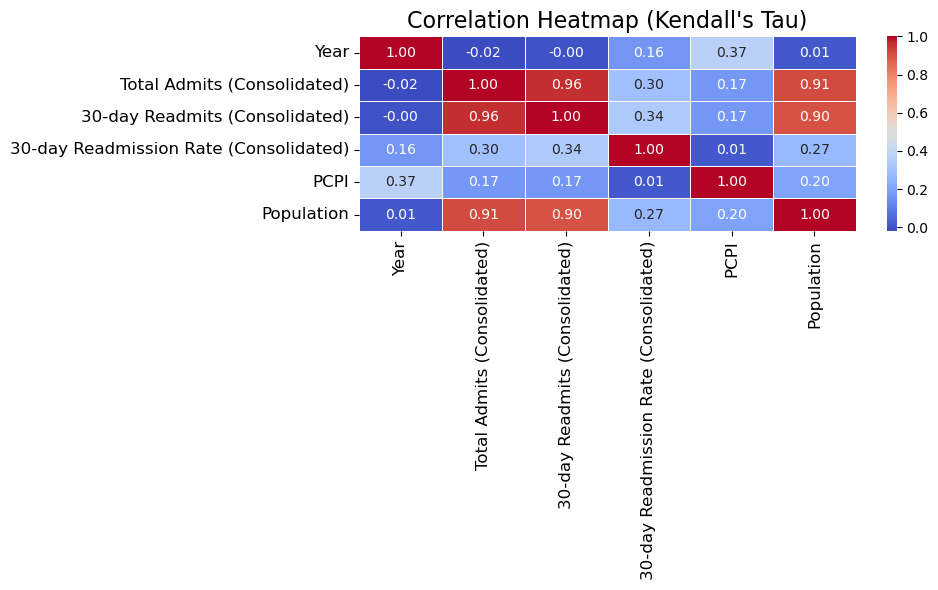

In [5]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(method='kendall'), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Kendall's Tau)", fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

A few noteworthy observations from this more robust calculation are:

1. Population's correlation with Total Admits and 30-day Readmits, while still very strong, is slightly reduced.

2. 30-day Readmission Rate's correlation with Total Admits and 30-day Readmits, while still weak, has grown by about 10% for each variable.

3. Population's correlation with 30-day Readmission Rate, while still weak, has also slightly increased.

Since evidence of the relationship between Total Admits and 30-day Readmits with 30-day Readmission Rate has been strengthened by the more robust correlation measurement, it should be insightful to visualize how these variables relate at a county level.

With that being said, since there is such a strong relationship between Population with Total Admits and 30-day Readmits, it should be helpful to transform these values into proportions of population first.

In [6]:
df['Total Admits (Proportion)'] = df['Total Admits (Consolidated)'] / df['Population']
df['30-day Readmits (Proportion)'] = df['30-day Readmits (Consolidated)'] / df['Population']
df.head()

Year     County ICD Version  Total Admits (Consolidated)  \
0  2011    Alameda       ICD-9                      75103.0   
1  2011     Alpine       ICD-9                         13.0   
2  2011     Amador       ICD-9                       2657.0   
3  2011      Butte       ICD-9                      20422.0   
4  2011  Calaveras       ICD-9                       3253.0   

   30-day Readmits (Consolidated)  30-day Readmission Rate (Consolidated)  \
0                         11377.0                                    15.1   
1                             1.0                                     7.7   
2                           345.0                                    13.0   
3                          3198.0                                    15.7   
4                           392.0                                    12.1   

      PCPI  Population  Total Admits (Proportion)  \
0  50432.0     1530893                   0.049058   
1  54040.0        1093                   0.011894   
2  34847.0       37539                   0.070780   
3  33669.0      219983                   0.092834   
4  37516.0       45159                   0.072034   

   30-day Readmits (Proportion)  
0                      0.007432  
1                      0.000915  
2                      0.009190  
3                      0.014537  
4                      0.008680

Now how do these transformed values correlate with the other variables?

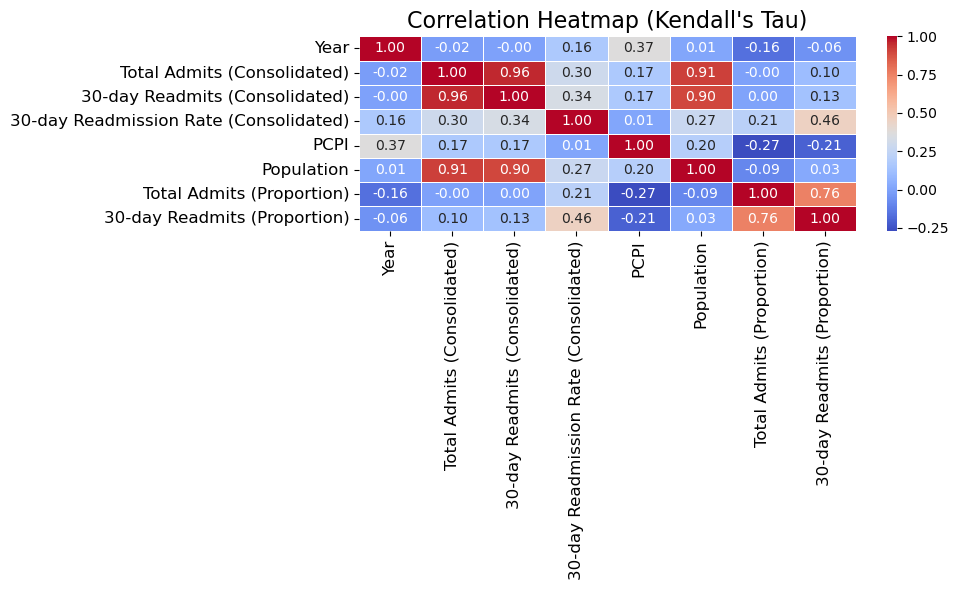

In [7]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(method='kendall'), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Kendall's Tau)", fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

From these transformed variables we can elucidate several important observations:

1. A strong correlation between Total Admits (Proportion) and 30-day Readmits (Proportion).
2. A moderate correlation between 30-day Readmission Rate and 30-day Readmits (Proportion).
3. A weak negative correlation for Total Admits (Proportion) and 30-day Readmits (Proportion) with Per Capita Personal Income (PCPI).

In [8]:
# Aggregate data to group by county (using median to reduce outlier effects)
county_level_data = df.groupby('County').agg({
    'Total Admits (Proportion)': 'median',
    '30-day Readmits (Proportion)': 'median',
    '30-day Readmission Rate (Consolidated)': 'median'
}).reset_index()

# Create an interactive scatterplot with a vibrant color scheme and larger points
fig = px.scatter(
    county_level_data,
    x="Total Admits (Proportion)",
    y="30-day Readmits (Proportion)",
    color="30-day Readmission Rate (Consolidated)",
    hover_name="County",  # Display county names on hover
    color_continuous_scale="Viridis",  # Use a vibrant color scheme
    size="30-day Readmission Rate (Consolidated)",  # Size based on readmission rate
    size_max=50,  # Maximum size for points
    title="Relationship Between Total Admits, 30-day Readmits, and Readmission Rate by County",
    labels={
        "Total Admits (Proportion)": "Total Admits (Proportion)",
        "30-day Readmits (Proportion)": "30-day Readmits (Proportion)",
        "30-day Readmission Rate (Consolidated)": "30-day Readmission Rate (%)"
    },
    width=1000,
    height=700  # Increase plot height
)

# Customize plot layout for aesthetics
fig.update_layout(
    xaxis_title="Total Admits (Proportion)",
    yaxis_title="30-day Readmits (Proportion)",
    coloraxis_colorbar=dict(
        title="30-day<br>Readmission Rate (%)"
    ),
    font=dict(size=14),
    plot_bgcolor="white",  # Set background color to white for a clean look
    title_font=dict(size=20, color="darkblue")  # Customize title font
)

# Customize axes appearance
fig.update_xaxes(showgrid=True, gridcolor="lightgrey", zeroline=False)
fig.update_yaxes(showgrid=True, gridcolor="lightgrey", zeroline=False)

# Show the plot
fig.show()


From this visual we can observe:

1. Most County Total Admits (Proportion) values fall between 3%-7% of the overall population.
2. Most County 30-day Readmits (Proportion) values fall between 3%-10%
3. Most County 30-day Readmission Rates values fall between 9%-13%
4. The smaller 30-day Readmission Rates tend to have smaller Total Admits (Proportion) and 30-day Readmits (Proportion).
5. The larger 30-day Readmission Rates tend to have larger Total Admits (Proportion) and 30-day Readmits (Proportion).

Although Per Capita Personal income is not directly correlated to 30-day Readmission Rate, its moderately negative correlation with Total Admits (Proportion) and 30-day Readmits Proportion may act as mediating variables since they are moderately correlated to 30-day Readmission Rate.

This intuition is worth testing in a subsequent notebook.

Finally the last step of this exploratory analysis will be to implement and visualize Principal Component Analysis (PCA).

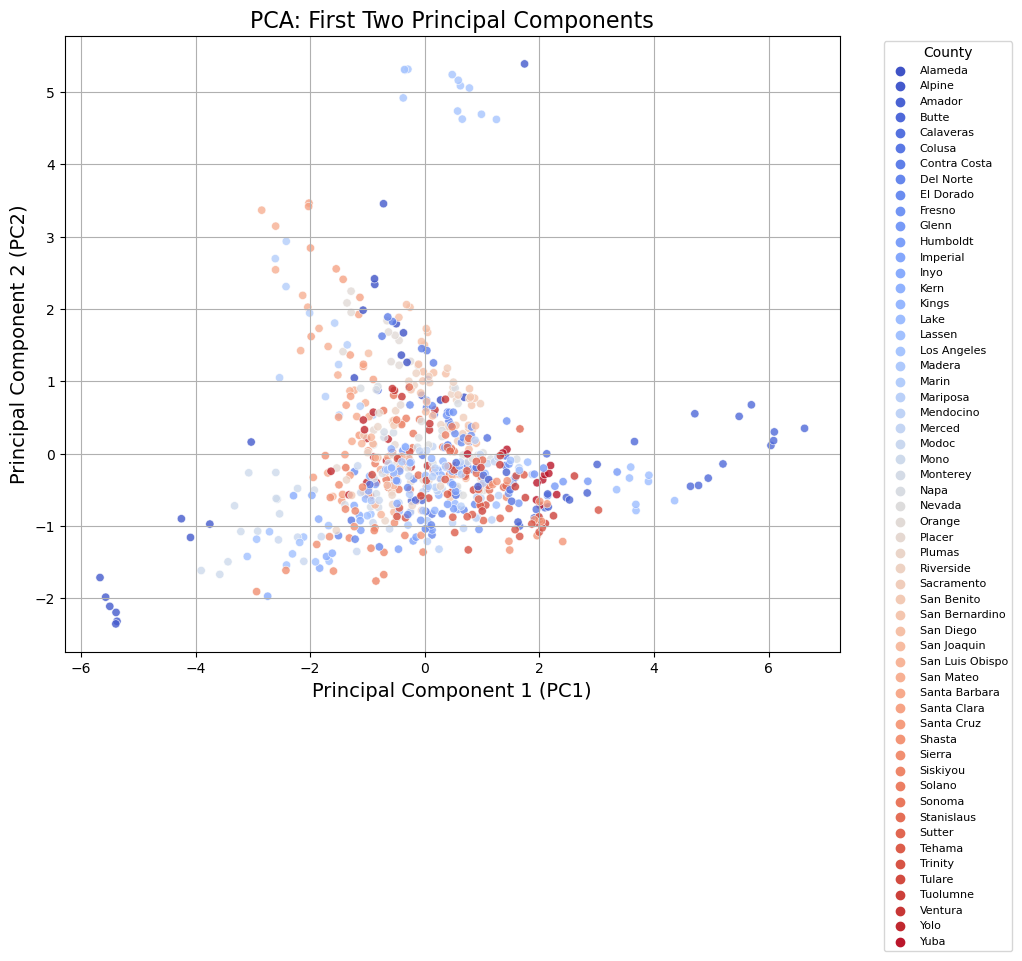

In [10]:
# Select only numeric columns for PCA
numeric_cols = ['PCPI', 'Total Admits (Proportion)', '30-day Readmits (Proportion)', '30-day Readmission Rate (Consolidated)', 'Population']
df_numeric = df[numeric_cols]

# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Step 2: Apply PCA
pca = PCA()
pca_result = pca.fit_transform(df_scaled)

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(
    pca_result,
    columns=[f"PC{i+1}" for i in range(len(pca.components_))]
)

# Step 3: Scatterplot of the First Two Principal Components
pca_df['County'] = df.reset_index()['County']  # Add county names for labeling
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=pca_df,
    hue="County",
    palette="coolwarm",
    alpha=0.8
)
plt.title("PCA: First Two Principal Components", fontsize=16)
plt.xlabel("Principal Component 1 (PC1)", fontsize=14)
plt.ylabel("Principal Component 2 (PC2)", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="County", fontsize=8)
plt.grid(True)
plt.show()


The two important focal points of this visual are: 

1. County Grouping- There appear to be 4-6 main clusters of counties
2. Feature contribution- Which features contribute most to PC1 and PC2?

The following visual will dig deeper into the second focal point.

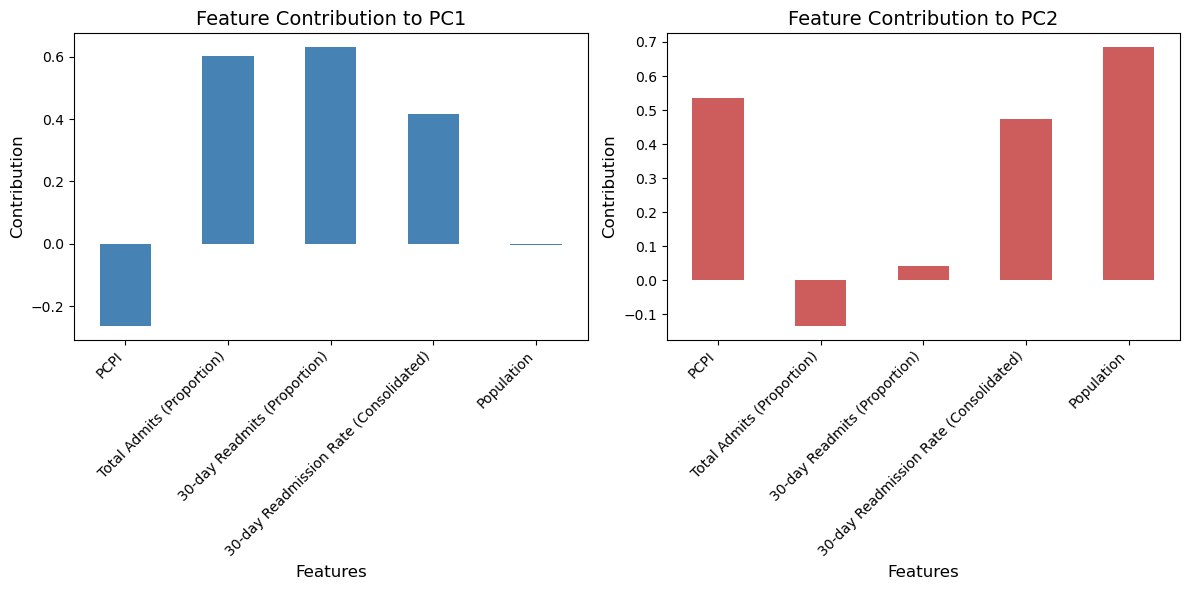

In [11]:
# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Step 2: Apply PCA
pca = PCA()
pca.fit(df_scaled)

# Step 3: Extract PCA loadings (components)
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to align features with components
    columns=[f"PC{i+1}" for i in range(len(pca.components_))],
    index=numeric_cols  # Feature names as the index
)

# Step 4: Visualize Feature Contributions for PC1 and PC2
plt.figure(figsize=(12, 6))

# Bar plot for PC1
plt.subplot(1, 2, 1)
loadings["PC1"].plot(kind='bar', color='steelblue')
plt.title("Feature Contribution to PC1", fontsize=14)
plt.ylabel("Contribution", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.xticks(rotation=45, ha='right')

# Bar plot for PC2
plt.subplot(1, 2, 2)
loadings["PC2"].plot(kind='bar', color='indianred')
plt.title("Feature Contribution to PC2", fontsize=14)
plt.ylabel("Contribution", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


The PCA reveals:

1. That PC1 distinguishes counties based on healthcare outcomes, with higher values linked to increased 30-day Readmits (Proportion) and Readmission Rates, along with lower PCPI (income). 

2. That PC2 captures differences in population and income, with higher values indicating larger, wealthier counties.

3. Distinct county clusters based on healthcare outcomes, income, and population:
    a) High PC1 and High PC2 counties are large urban areas with higher populations and readmission metrics but lower income levels.
    b) High PC1 and Low PC2 counties are smaller, less populous regions with poor healthcare outcomes and low income.
    c) Low PC1 and High PC2 counties are affluent areas with better healthcare outcomes and high populations.
    d) Low PC1 and Low PC2 counties are small rural regions with low income, population, and healthcare utilization.
    e) The central cluster represents counties with average metrics across these factors.
    
    Outliers warrant further investigation for unique challenges or conditions.

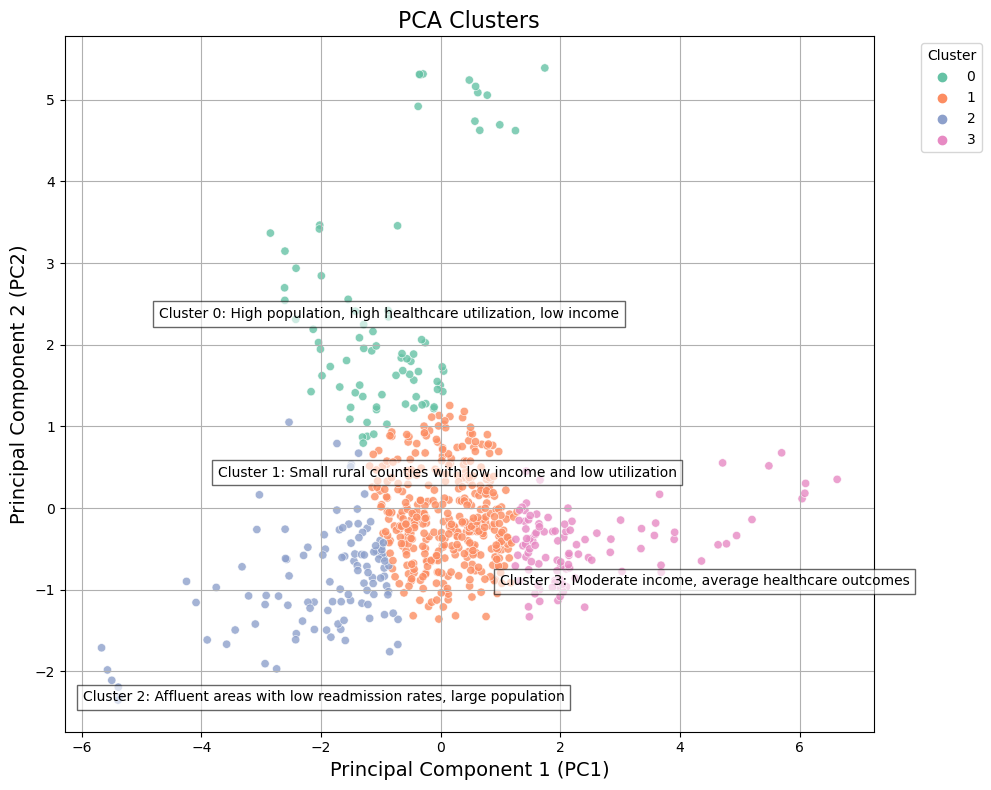

In [22]:
from sklearn.cluster import KMeans

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Define interpretations for each cluster
cluster_interpretations = {
    0: "High population, high healthcare utilization, low income",
    1: "Small rural counties with low income and low utilization",
    2: "Affluent areas with low readmission rates, large population",
    3: "Moderate income, average healthcare outcomes"
}

# Visualize Clusters on PCA Plot
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(
    x='PC1', y='PC2', hue='Cluster', data=pca_df,
    palette='Set2', alpha=0.8
)
plt.title("PCA Clusters", fontsize=16)
plt.xlabel("Principal Component 1 (PC1)", fontsize=14)
plt.ylabel("Principal Component 2 (PC2)", fontsize=14)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add cluster interpretation text to the plot
# Adjust the positions of the cluster interpretation text
for cluster_id, interpretation in cluster_interpretations.items():
    # Get the cluster center from K-Means
    cluster_center = kmeans.cluster_centers_[cluster_id]

    # Adjust text positions for specific clusters
    if cluster_id == 2:  # Move Cluster 2 down
        cluster_center[1] -= 1.5
    elif cluster_id == 3:  # Move Cluster 3 to the right
        cluster_center[0] += 2
        cluster_center[1] -= .5
    elif cluster_id == 1: 
        cluster_center[1] += .5

    # Add the text to the plot
    plt.text(
        cluster_center[0], cluster_center[1],  # Position
        f"Cluster {cluster_id}: {interpretation}",
        fontsize=10, color='black', ha='center', bbox=dict(facecolor='white', alpha=0.6)
    )


plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
#Save the dataframe with transformed values as csv
df.to_csv('primary.csv',index=False)